# Modelo de predicción de éxito de las startups

**PARTE 2: SELECCIÓN DE VARIABLES Y CREACIÓN DE MODELOS**

## 1. Importación de librerías

**Librerías generales**

In [1]:
import os
import pandas as pd
import numpy as np
import itertools

**Librerías para gráficos**

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Librerías para construcción de modelos**

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             precision_score, recall_score, f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso

**Configuración**

In [4]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## 2. Importación de datos

Importamos los datos de los dos ficheros depurados que vamos a probar:

- **startups_depurado_frequency**: variables categóricas recodificadas con su frecuencia relativa
- **startups_depurado_propsuccess**: variables categóricas recodificadas con su proporción de casos *success*

In [5]:
# Rutas de los ficheros
current_path = os.getcwd() # obtener la ruta donde se guarda este cuaderno
dataset_freq_path = current_path + '/startups_depurado_frequency.csv' # Fichero depurado: Frecuency Encoder
dataset_prop_path = current_path + '/startups_depurado_propsuccess.csv' # Fichero depurado: Proportion Success Encoder

# Lectura de los ficheros
df_startups_freq = pd.read_csv(dataset_freq_path, na_values=['none','None'])
df_startups_prop = pd.read_csv(dataset_prop_path, na_values=['none','None'])

In [6]:
len(df_startups_freq.columns)

111

In [7]:
len(df_startups_prop.columns)

111

## 3. Feature selection

Hacemos la selección de variables mediante el cálculo individual del AUC. Probaremos distintos modelos cambiando el punto de corte *threshold*.

**NOTA:** He ejecutado el código para los dos ficheros y las variables correlacionadas son las mismas, por lo tanto las elimino en los dos ficheros

**POSIBLES VARIABLES CONFLICTIVAS**

En general, todas las variables relacionadas con la experiencia de la empresa no las podemos saber a priori si queremos predecir el éxito/fracaso de las empresas en el momento de la creación. Es información que no vamos a poder tener con las nuevas observaciones.

- **age_years**: directamente relacionada con la variable objetivo (*Success* si la empresa sigue en activo a los X años, *Failed* si cierra antes de X años)
- **fundation_year**: mismo motivo
- **has_team_size_grown**: ha aumentado el tamaño del equipo. Info que a priori no podemos saber.
- **number_repeat_investors**: inversores que repiten. Info que a priori no podemos saber.
- **avg_size_companies_worked_for_past**: tampoco podemos saberlo en el inicio de la empresa
- **breadth_experience_across_verticals**
- **experience_fortune_100_organizations**
- **experience_fortune_500_organizations**
- **experience_fortune_1000_organizations**
- **company_awards**: si tiene premios es porque ha tenido éxito
- **employees_per_year_existence**: los años de existencia no los podemos conocer
- **survival_through_recession**
- **avg_time_to_investment**: a priori no podemos saber.
- **renown_score**: puntuación de renombre. Si tiene renombre es porque ha tenido éxito

Tengo más dudas de estas:
- **days_since_last_funding_date**
- **days_since_est_funding_date**
- **exposure_across_globe**

In [8]:
# Eliminamos variables conflictivas de ambos ficheros
vars_conflict = ["age_years", "fundation_year", "has_team_size_grown", "number_repeat_investors", "avg_size_companies_worked_for_past", "breadth_experience_across_verticals", "experience_fortune_100_organizations", "experience_fortune_500_organizations",
                 "experience_fortune_1000_organizations", "company_awards", "employees_per_year_existence", "survival_through_recession", "avg_time_to_investment", "renown_score", "exposure_across_globe", "days_since_last_funding_date", "days_since_est_funding_date"]

df_noconflict_freq = df_startups_freq.drop(vars_conflict, axis=1)  # fichero STARTUP_FREQUENCY
df_noconflict_prop = df_startups_prop.drop(vars_conflict, axis=1)  # fichero STARTUP_PROPORTION

### 3.1. Estudio de correlaciones

Sacamos un gráfico de correlaciones de las variables numéricas para tratar de eliminar variables que estén muy correlacionadas, ya que aportan información redundante.

#### 3.1.1. Fichero STARTUP_FREQUENCY

In [9]:
df_numeric = df_noconflict_freq.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [10]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.012164       -0.038585   
focus_functions                                  0.100775        0.092437   
country                                          0.021442       -0.002080   
continent                                        0.043552       -0.018571   
presence_angel_venture_fund                      0.102967        0.037925   
number_sales_support_material                    0.267919       -0.048605   
worked_top_company                               0.024288        0.048503   
part_of_startups_past                            0.114789        0.011491   
part_of_success_startups_past                    0.161857        0.025298   
partner_big5_consulting                          0.053713        0.022892   
consulting_experience                            0.305352        0.086462   
product_or_service_company                       0.036030       -0.006956   
catering_product_service_across_verticals        0.204340        0.059634   
focus_private_or_public_data                    -0.053657       -0.050467   
focus_consumer_data                             -0.071792        0.071789   
focus_structured_unstructured_data               0.200132        0.028617   
subscription_based                               0.169877        0.056974   
cloud_or_platform_based                         -0.188696        0.027429   
local_or_global_player                         

In [11]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [12]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'controversial_history_founder_cofounder',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered']

**Variables correlacionadas**:

- last_round_fundind_millionUSD:
    - last_funding_amount                                0.795699
- continent:
    - country                                            0.966224
- part_of_success_startups_past:
    - part_of_startups_past                              0.841086
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764

In [13]:
# Eliminamos variables correlacionadas del fichero STARTUP_FREQUENCY
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "technical_skills_analyse_unstructured_data",
                    "pricing_strategy", "controversial_history_founder_cofounder", "team_composition_score", "difficulty_obtain_workforce",
                    "disruptiveness_technology", "long_term_relation_other_founders", "legal_risk_intell_property", "proprietary_patent_position",
                    "time_market_service_product", "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "client_reputation", "top_management_similarity", "solutions_offered", "relevance_experience_venture", "google_page_rank_company_web", "invested_through_global_incubation_competitions"]

df_corr_elim_freq = df_noconflict_freq.drop(vars_to_drop_def, axis=1)
df_corr_elim_freq.shape

(472, 72)

In [14]:
input_cols_freq = df_corr_elim_freq.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

#### 3.1.2. Fichero STARTUP_PROPORTION

In [15]:
df_numeric = df_noconflict_prop.select_dtypes(include=["float64"]) # selecciono numericas
corr_df = df_numeric.corr()

In [16]:
corr_df # matriz de correlaciones

status  internet_score  \
status                                           1.000000        0.202803   
internet_score                                   0.202803        1.000000   
count_employee                                   0.071115        0.139861   
last_funding_amount                             -0.025432        0.067705   
number_investors_seed                            0.131532        0.114626   
number_investors_angel_VC                        0.049643       -0.063713   
number_cofounders                                0.205835        0.089144   
number_advisors                                  0.188963        0.039660   
team_size_senior_lead                            0.255690        0.123083   
team_size_all_employees                          0.036745        0.204459   
years_education                                  0.027094       -0.022166   
renowned_professional_circle                     0.140332        0.091063   
number_recognitions_for_founders_cofounders      0.153254        0.081916   
skills_score                                    -0.025790        0.024571   
google_page_rank_company_web                    -0.194879       -0.242407   
industry_trend_investing                         0.025436       -0.003328   
number_direct_competitors                        0.039833       -0.028976   
last_round_fundind_millionUSD                    0.013187        0.070292   
months_to_1st_investment                         0.076327       -0.005395   
perc_skill_entrepreneur                          0.063521        0.020376   
perc_skill_operations                           -0.036708       -0.084150   
perc_skill_engineering                           0.079733       -0.004266   
perc_skill_marketing                             0.032886        0.087828   
perc_skill_leadership                            0.063092       -0.037954   
perc_skill_datascience                           0.169279        0.031580   
perc_skill_business_strategy                    -0.065240       -0.050652   
perc_skill_product_manag                        -0.054518       -0.006236   
perc_skill_sales                                 0.009310       -0.079295   
perc_skill_domain                               -0.041169       -0.121623   
perc_skill_law                                   0.038897       -0.040585   
perc_skill_consulting                            0.058681       -0.005239   
perc_skill_finance                               0.003311       -0.052541   
perc_skill_investment                           -0.003900        0.005861   
industry                                         0.115450       -0.020005   
focus_functions                                  0.157066        0.102823   
country                                          0.051657       -0.005055   
continent                                        0.082191       -0.021006   
presence_angel_venture_fund                      0.142657        0.057951   
number_sales_support_material                    0.465757        0.076252   
worked_top_company                               0.036021        0.052279   
part_of_startups_past                            0.127295        0.018592   
part_of_success_startups_past                    0.191643        0.049676   
partner_big5_consulting                          0.063496        0.027167   
consulting_experience                            0.304666        0.063277   
product_or_service_company                       0.042346       -0.007817   
catering_product_service_across_verticals        0.360891        0.117526   
focus_private_or_public_data                     0.297465        0.039052   
focus_consumer_data                              0.088373        0.067462   
focus_structured_unstructured_data               0.416470        0.071971   
subscription_based                               0.162540        0.054927   
cloud_or_platform_based                         -0.178484        0.025434   
local_or_global_player                         

In [17]:
corr_df_abs = corr_df.abs()  # matriz de correlaciones en valor absoluto
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(np.bool))  # triángulo superior de la matriz
vars_to_drop = [c for c in upper.columns if any(upper[c] > 0.75)]  # variables con correlación >0.75

In [18]:
vars_to_drop

['last_round_fundind_millionUSD',
 'continent',
 'part_of_success_startups_past',
 'pricing_strategy',
 'time_market_service_product',
 'long_term_relation_other_founders',
 'proprietary_patent_position',
 'controversial_history_founder_cofounder',
 'legal_risk_intell_property',
 'technical_skills_analyse_unstructured_data',
 'solutions_offered',
 'disruptiveness_technology']

**Variables correlacionadas**:

- last_round_fundind_millionUSD: 
    - last_funding_amount (0.79)
- continent: 
    - country (0.96)
- part_of_success_startups_past: 
    - part_of_startups_past (0.84)
- pricing_strategy:
    - avg_years_experience for founder and co founder    0.722795
    - highest_education                                  0.724434
    - hyper_localisation                                 0.748862
    - legal_risk_intell_property                         0.761779
    - proprietary_patent_position                        0.762992
    - long_term_relation_other_founders                  0.763557
    - time_market_service_product                        0.776864
    - disruptiveness_technology                          0.787571
    - difficulty_obtain_workforce                        0.797210
    - team_composition_score                             0.910380
    - controversial_history_founder_cofounder            0.916762
    - technical_skills_analyse_unstructured_data         0.965417
    - solutions_offered                                  0.983764
- time_market_service_product:
    - team_composition_score                             0.711910
    - controversial_history_founder_cofounder            0.733871
    - technical_skills_analyse_unstructured_data         0.755792
    - solutions_offered                                  0.765559
    - pricing_strategy                                   0.776864
- long_term_relation_other_founders:
    - team_composition_score                             0.728845
    - technical_skills_analyse_unstructured_data         0.753278
    - pricing_strategy                                   0.763557
    - solutions_offered                                  0.773206
- proprietary_patent_position:
    - controversial_history_founder_cofounder            0.716158
    - team_composition_score                             0.733217
    - technical_skills_analyse_unstructured_data         0.746133
    - pricing_strategy                                   0.762992
    - solutions_offered                                  0.766714
- controversial_history_founder_cofounder:
    - proprietary_patent_position                        0.716158
    - hyper_localisation                                 0.719162
    - time_market_service_product                        0.733871
    - difficulty_obtain_workforce                        0.750313
    - legal_risk_intell_property                         0.760663
    - disruptiveness_technology                          0.775242
    - team_composition_score                             0.847335
    - solutions_offered                                  0.905945
    - pricing_strategy                                   0.916762
    - technical_skills_analyse_unstructured_data         0.919250
- legal_risk_intell_property:
    - team_composition_score                             0.701082
    - technical_skills_analyse_unstructured_data         0.752223
    - controversial_history_founder_cofounder            0.760663
    - pricing_strategy                                   0.761779
    - solutions_offered                                  0.771843
- technical_skills_analyse_unstructured_data:
    - highest_education                                  0.713242
    - avg_years_experience for founder and co founder    0.729571
    - proprietary_patent_position                        0.746133
    - legal_risk_intell_property                         0.752223
    - long_term_relation_other_founders                  0.753278
    - time_market_service_product                        0.755792
    - hyper_localisation                                 0.756245
    - disruptiveness_technology                          0.791730
    - difficulty_obtain_workforce                        0.799461
    - team_composition_score                             0.885346
    - controversial_history_founder_cofounder            0.919250
    - pricing_strategy                                   0.965417
    - solutions_offered                                  0.967035
- solutions_offered:
    - avg_years_experience for founder and co founder    0.722453
    - highest_education                                  0.723791
    - hyper_localisation                                 0.742106
    - time_market_service_product                        0.765559
    - proprietary_patent_position                        0.766714
    - legal_risk_intell_property                         0.771843
    - long_term_relation_other_founders                  0.773206
    - disruptiveness_technology                          0.784060
    - difficulty_obtain_workforce                        0.800028
    - team_composition_score                             0.890685
    - controversial_history_founder_cofounder            0.905945
    - technical_skills_analyse_unstructured_data         0.967035
    - pricing_strategy                                   0.983764
- disruptiveness_technology:
    - team_composition_score                             0.711677
    - controversial_history_founder_cofounder            0.775242
    - solutions_offered                                  0.784060
    - pricing_strategy                                   0.787571
    - technical_skills_analyse_unstructured_data         0.791730

In [19]:
# Eliminamos variables correlacionadas del fichero STARTUP_PROPORTION
vars_to_drop_def = ["last_round_fundind_millionUSD", "continent", "part_of_success_startups_past", "solutions_offered",
                    "technical_skills_analyse_unstructured_data", "controversial_history_founder_cofounder", "team_composition_score",
                    "difficulty_obtain_workforce", "disruptiveness_technology", "time_market_service_product",
                    "long_term_relation_other_founders", "proprietary_patent_position", "legal_risk_intell_property",
                    "hyper_localisation", "highest_education", "avg_years_experience for founder and co founder",
                    "pricing_strategy", "invested_through_global_incubation_competitions", "experience_selling_building_products", "google_page_rank_company_web", "client_reputation"]

df_corr_elim_prop = df_noconflict_prop.drop(vars_to_drop_def, axis=1)
df_corr_elim_prop.shape

(472, 73)

In [20]:
input_cols_prop = df_corr_elim_prop.select_dtypes(include=["float64"]).columns.drop('status') # selecciono numericas

### 3.2. Selección de variables

La selección de variables es diferente en cada dataset

**Selección mediante AUC**

In [21]:
def get_auc(df, score_col, label_col): 
    
    """
    Función que calcula el AUC de una variable con respecto a la variable objetivo
    
    - df: dataframe que contiene la variable input y label
    - score_col: columna de la variable input
    - label_col: columna de la variable objetivo
    
    """
    
    #1. Compruebo dirección de la variable input con respecto a la objetivo (ajuste para que no salgan AUC negativos)
    
    avg_df = df.groupby(label_col)[score_col].mean() #media de la variable input para label=success y label=failure
    avg_failed = avg_df.values[0] #media de la variable input para label=failed
    avg_success = avg_df.values[1] #media de la variable input para label=success
    
    if avg_failed > avg_success: #si la media de la variable input para label=failed es superior que para label=success 

        df[score_col] = -1.0*df[score_col] #paso la variable input a negativa
        
    else: #si la media de la variable input para label=success es superior que para label=failed

        df #dejo la variable input igual
    
    #2. Paso las columnas label e input a array para poder calcular AUC

    x = df[score_col].to_numpy() 
    y = df[label_col].to_numpy()

    #3. Calculo AUC de la variable input con respecto a la variable objetivo
    
    auc = roc_auc_score(y, x) 

    return auc

In [22]:
def feature_selection_auc(df, threshold, cols_to_filter, label_col = 'status'): 

    """
    Función que aplica get_auc sobre todas las variables input y selecciona aquellas con un AUC superior
    
    - df: dataframe que contiene las variables input y label
    - threshold: AUC a partir del cuál me quedo con una variable 
    - cols_to_filter: columnas sobre las que queremos calcular el AUC
    - label_col: columna de la variable objetivo
    """
    
    #1. Calculo AUC de todas las variables input y las guardo en una tupla ordenada de mayor a menor AUC
    
    auc_results = [(f, get_auc(df, score_col=f, label_col=label_col)) for f in cols_to_filter] 
    auc_results = sorted(auc_results, key=lambda tup: tup[1], reverse=True)

    #2. Imprimo por pantalla los resultados
    
    for (f, r) in auc_results:
            print ("[Info] " + f + ": " + str(r))
            
            
    #3. Me quedo con aquellas variables cuyo AUC sea superior al threshold que indiquemos
    
    auc_greater = [list(group) for val, group in itertools.groupby(auc_results, lambda x: x[1] > threshold) if val]
 
    vars_selected = [var for var, auc in auc_greater[0]]
    
    return vars_selected

**NOTA**: Hay que jugar con el punto de corte hasta llegar al número de variables independientes deseado (mínimo 0.5)

## 4. Prueba de diferentes modelos

### Modelo 1: Transformación FREQUENCY, AUC > 0.5. RF

Seleccionamos variables con un AUC superior a 0.5, con el dataset de frecuencias:

In [23]:
vars_selected_freq1 = feature_selection_auc(df_corr_elim_freq, 0.5, input_cols_freq, label_col = 'status') 

[Info] relevance_education_venture: 0.7441150485913419
[Info] local_or_global_player: 0.7277706881319328
[Info] gartner_hype_cycle_stage: 0.7197113968783744
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] big_data_business: 0.6909983312064396
[Info] B2C_or_B2B: 0.6855502110533032
[Info] focus_structured_unstructured_data: 0.6720329832139
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] consulting_experience: 0.6406792971434181
[Info] number_cofounders: 0.6267105133994306
[Info] predictive_analytics_business: 0.624305487385884
[Info] number_sales_support_material: 0.6238833807794247
[Info] industry_trend_investing: 0.6139000687150289
[Info] barriers_entry_competitors: 0.6058211445960537
[Info] perc_skill_investment: 0.5956611367429075
[Info] internet_score: 0.5903504466476882
[Info] perc_skill_

In [24]:
len(vars_selected_freq1) #se queda con 55 variables de las 72 que teníamos tras eliminar correladas

55

Creamos el dataset para el primer modelo, con las variables input seleccionadas, la variable target y la identificadora de la empresa

In [25]:
df_model1 = df_startups_freq[['company_name'] + ['status'] + vars_selected_freq1]

Dividimos en train y test: decidimos entrenar con el 70% de los datos y validar con el 30% restante

In [26]:
train1, test1 = train_test_split(df_model1,
                                 train_size=0.7,
                                 test_size=0.3)

Aplicamos el modelo con los datos de train (parámetro class_weight para balancear)

In [27]:
model1_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [28]:
model1 = model1_rf.fit(train1[vars_selected_freq1],
                       train1['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Sacamos importancia de variables del modelo entrenado:

In [29]:
feat_importances_model1 = pd.DataFrame(model1.feature_importances_,
                                       index=vars_selected_freq1,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [30]:
feat_importances_model1

importance
renowned_professional_circle                   0.093244
perc_skill_datascience                         0.071385
number_recognitions_for_founders_cofounders    0.071080
relevance_education_venture                    0.063725
employee_benefits_salary_structures            0.059518
industry_trend_investing                       0.056450
focus_structured_unstructured_data             0.052171
local_or_global_player                         0.044905
focus_private_or_public_data                   0.029509
internet_score                                 0.029413
cloud_or_platform_based                        0.026856
perc_skill_engineering                         0.023327
industry                                       0.020533
predictive_analytics_business                  0.018359
perc_skill_business_strategy                   0.018172
gartner_hype_cycle_stage                       0.017359
perc_skill_entrepreneur                        0.016855
last_funding_amount                            0.016203
specialization_highest_education               0.015161
degree_tier1_tier2_university                  0.015069
cross_channel_analytics_or_marketing           0.014330
team_size_senior_lead                          0.013887
number_sales_support_material                  0.013879
ML_business                                    0.012893
skills_score                                   0.012447
focus_consumer_data                            0.011246
top_forums_talking_about_company               0.011201
prescriptive_analytics_business                0.011109
country                                        0.010990
perc_skill_domain                              0.010028
part_of_startups_past                          0.009642
product_or_service_company                     0.008806
number_advisors                                0.008079
barriers_entry_competitors                     0.007872
number_cofounders                              0.007300
years_education                                0.007263
linear_nonlinear_business                      0.006758
online_or_offline_business                     0.006589
aggregator_or_market_place                     0.006449
perc_skill_operations                          0.005301
capital_intensive                              0.004813
perc_skill_investment                          0.004585
subscription_based                             0.004568
big_data_business                              0.004523
consulting_experience                          0.004111
presence_angel_venture_fund                    0.003794
owns_data                                      0.003779
crowdsourcing_business                         0.003699
perc_skill_product_manag                       0.003652
B2C_or_B2B                                     0.002050
crowdfunding_business                          0.002012
number_investors_seed                          0.001526
speech_analytics_business                      0.000922
worked_top_company                             0.000605
partner_big5_consulting                        0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [31]:
test = test1
model = model1
feature_columns = vars_selected_freq1

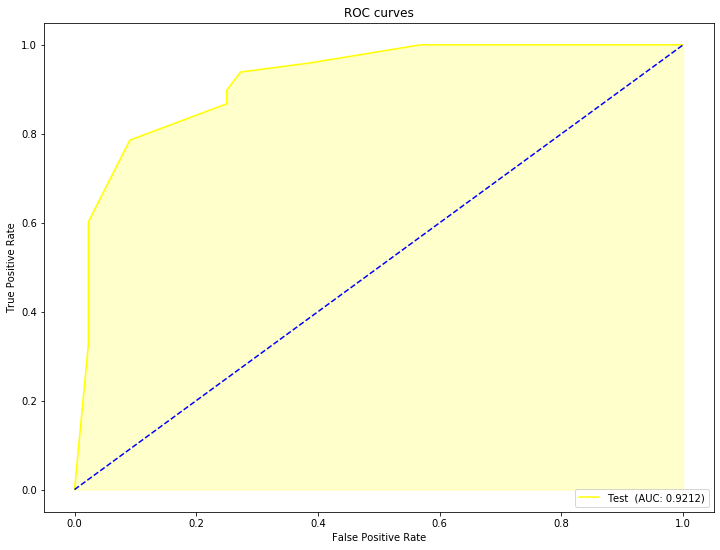

In [32]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1], pos_label=1.0)
df_roc_test = pd.DataFrame({"fpr": fpr, "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [33]:
auc_test

0.9211502782931354

In [34]:
auc_train = roc_auc_score(train1['status'],
                          model.predict_proba(train1[feature_columns])[:, 1])

In [35]:
auc_train

0.9999410863673854

**COMENTARIO**: El AUC en train es demasiado alto (prácticamente 1), y hay algo de overfitting (en test el AUC es inferior). Sin embargo, no podemos decir que haya demasiado overfitting, ya que prácticamente son igual de altos. 

### Modelo 2: Transformación PROPORTION, AUC > 0.5. RF

Ahora seleccionamos variables con un AUC superior a 0.5, con el dataset de proporción objetivo:

In [36]:
vars_selected_prop2 = feature_selection_auc(df_corr_elim_prop, 0.5, input_cols_prop, label_col = 'status') 

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [37]:
len(vars_selected_prop2) #se queda con 59 variables de las 73 que teníamos tras eliminar correladas

59

In [38]:
df_model2 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop2]

In [39]:
train2, test2 = train_test_split(df_model2,
                                 train_size=0.7,
                                 test_size=0.3)

In [40]:
model2_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [41]:
model2 = model2_rf.fit(train2[vars_selected_prop2],
                       train2['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [42]:
feat_importances_model2 = pd.DataFrame(model2.feature_importances_,
                                       index=vars_selected_prop2,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [43]:
feat_importances_model2

importance
specialization_highest_education               0.079804
local_or_global_player                         0.077274
relevance_education_venture                    0.076951
number_sales_support_material                  0.061975
relevance_experience_venture                   0.055416
focus_private_or_public_data                   0.041991
perc_skill_datascience                         0.038705
industry                                       0.034270
renowned_professional_circle                   0.034238
top_management_similarity                      0.028130
perc_skill_entrepreneur                        0.027874
number_recognitions_for_founders_cofounders    0.027080
last_funding_amount                            0.026883
skills_score                                   0.024065
number_cofounders                              0.021716
perc_skill_product_manag                       0.019929
focus_structured_unstructured_data             0.019164
perc_skill_engineering                         0.018816
internet_score                                 0.018810
degree_tier1_tier2_university                  0.016529
country                                        0.015711
gartner_hype_cycle_stage                       0.015357
team_size_senior_lead                          0.015246
perc_skill_domain                              0.015155
perc_skill_business_strategy                   0.012821
top_forums_talking_about_company               0.012814
perc_skill_operations                          0.012378
B2C_or_B2B                                     0.011145
number_advisors                                0.010864
industry_trend_investing                       0.010124
time_maturity_technology                       0.008848
cloud_or_platform_based                        0.008488
crowdsourcing_business                         0.008324
number_investors_seed                          0.006250
subscription_based                             0.006085
focus_functions                                0.005541
employee_benefits_salary_structures            0.005524
big_data_business                              0.005283
prescriptive_analytics_business                0.005266
product_or_service_company                     0.005041
linear_nonlinear_business                      0.004942
presence_angel_venture_fund                    0.004809
speech_analytics_business                      0.004728
aggregator_or_market_place                     0.004501
perc_skill_investment                          0.004304
partner_big5_consulting                        0.004089
online_or_offline_business                     0.003978
predictive_analytics_business                  0.003702
cross_channel_analytics_or_marketing           0.003527
catering_product_service_across_verticals      0.002735
consulting_experience                          0.002559
owns_data                                      0.001980
part_of_startups_past                          0.001864
worked_top_company                             0.001814
barriers_entry_competitors                     0.001664
capital_intensive                              0.001231
ML_business                                    0.001092
years_education                                0.000598
crowdfunding_business                          0.000000

**Evaluación del modelo: Curva ROC y AUC**

In [44]:
test = test2
model = model2
feature_columns = vars_selected_prop2

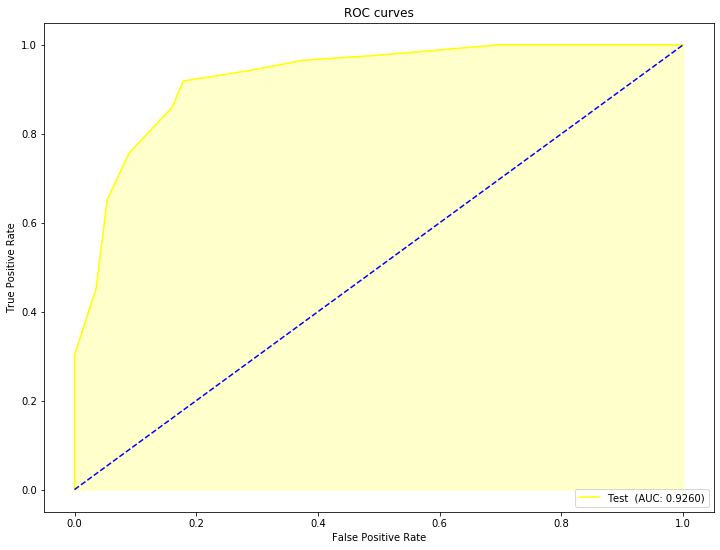

In [45]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [46]:
auc_test

0.9259759136212624

In [47]:
auc_train = roc_auc_score(train2['status'],
                          model.predict_proba(train2[feature_columns])[:, 1])

In [48]:
auc_train

1.0

**COMENTARIO**: Aquí el AUC en test aumenta un poco, y en train sigue igual que en el anterior modelo (prácticamente 1)

### Modelo 3: Transformación PROPORTION, AUC > 0.6. RF

Ahora, con el dataset de proporción objetivo, probamos a aumentar el threshold de AUC para introducir menos variables en el modelo (no es recomendable que tengamos casi el mismo número de variables que de observaciones en los datos de test)

In [26]:
vars_selected_prop3 = feature_selection_auc(df_corr_elim_prop, 0.6, input_cols_prop, label_col='status')

[Info] relevance_experience_venture: 0.7600274860115834
[Info] relevance_education_venture: 0.7441150485913419
[Info] focus_structured_unstructured_data: 0.7396682045744576
[Info] local_or_global_player: 0.7277706881319328
[Info] big_data_business: 0.7209384509669187
[Info] top_management_similarity: 0.7135761264356532
[Info] renowned_professional_circle: 0.7067733385687641
[Info] degree_tier1_tier2_university: 0.6960930597820753
[Info] team_size_senior_lead: 0.6941199568076961
[Info] number_sales_support_material: 0.6896142141945617
[Info] B2C_or_B2B: 0.6855502110533032
[Info] catering_product_service_across_verticals: 0.6815058407774615
[Info] top_forums_talking_about_company: 0.6718759202905664
[Info] gartner_hype_cycle_stage: 0.6636399332482575
[Info] aggregator_or_market_place: 0.6571807205261608
[Info] focus_private_or_public_data: 0.6569254932757436
[Info] focus_functions: 0.6539020320015706
[Info] employee_benefits_salary_structures: 0.6538235005399038
[Info] specialization_hig

In [27]:
len(vars_selected_prop3) #se queda con 24 variables

24

In [28]:
vars_selected_prop3

['relevance_experience_venture',
 'relevance_education_venture',
 'focus_structured_unstructured_data',
 'local_or_global_player',
 'big_data_business',
 'top_management_similarity',
 'renowned_professional_circle',
 'degree_tier1_tier2_university',
 'team_size_senior_lead',
 'number_sales_support_material',
 'B2C_or_B2B',
 'catering_product_service_across_verticals',
 'top_forums_talking_about_company',
 'gartner_hype_cycle_stage',
 'aggregator_or_market_place',
 'focus_private_or_public_data',
 'focus_functions',
 'employee_benefits_salary_structures',
 'specialization_highest_education',
 'consulting_experience',
 'number_cofounders',
 'predictive_analytics_business',
 'industry_trend_investing',
 'barriers_entry_competitors']

In [29]:
df_model3 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [30]:
df_model3 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [31]:
train3, test3 = train_test_split(df_model3,
                                 train_size=0.7,
                                 test_size=0.3)

In [53]:
model3_rf = RandomForestClassifier(class_weight='balanced')  # class 1: 64.6%, class 0: 35.4%

In [54]:
model3 = model3_rf.fit(train3[vars_selected_prop3],
                       train3['status'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
feat_importances_model3 = pd.DataFrame(model3.feature_importances_,
                                       index=vars_selected_prop3,
                                       columns=['importance']).sort_values('importance', ascending=False)

In [56]:
feat_importances_model3

importance
focus_structured_unstructured_data           0.084886
specialization_highest_education             0.082189
relevance_education_venture                  0.079228
industry_trend_investing                     0.063333
relevance_experience_venture                 0.060144
local_or_global_player                       0.051419
number_sales_support_material                0.050255
team_size_senior_lead                        0.047262
focus_functions                              0.043969
number_cofounders                            0.041829
top_forums_talking_about_company             0.037870
catering_product_service_across_verticals    0.037514
employee_benefits_salary_structures          0.036911
gartner_hype_cycle_stage                     0.034996
renowned_professional_circle                 0.034711
predictive_analytics_business                0.034308
big_data_business                            0.034182
top_management_similarity                    0.027055
B2C_or_B2B                                   0.023402
aggregator_or_market_place                   0.022795
degree_tier1_tier2_university                0.022165
focus_private_or_public_data                 0.020109
consulting_experience                        0.015479
barriers_entry_competitors                   0.013988

**Evaluación del modelo: Curva ROC y AUC**

In [92]:
test=test3
model=model3
feature_columns=vars_selected_prop3

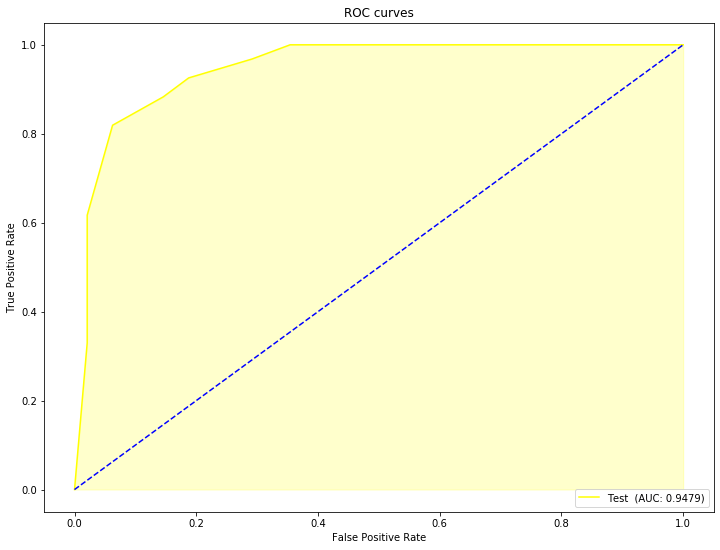

In [93]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [59]:
auc_test

0.9479166666666667

In [60]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [61]:
auc_train

0.9999800868214586

**COMENTARIO**: Aquí tenemos un resultado similar al del modelo anterior. Sin embargo, hemos introducido casi la mitad de variables, por lo que este modelo es más recomendable

### Modelo 3_1: Transformación PROPORTION, AUC > 0.6. RF + Grid search Cross Validation

Una técnica para reducir el sobreajuste es la validación cruzada. Utilizamos GridSearchCV, que nos permite entrenar de forma automática distintos modelos, variando para cada uno de ellos el conjunto de entrenamiento seleccionado y los valores de los hiperparámetros.

Utilizamos el mismo dataset que en el modelo anterior (categóricas transformadas a proporción objetivo, filtrando variables por AUC>0.6): train3, test3

In [133]:
model3_1_rf = RandomForestClassifier(class_weight='balanced')

param_grid3_1 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }

grid3_1 = GridSearchCV(estimator=model3_1_rf,
                       param_grid=param_grid3_1,
                       scoring="roc_auc",  # métrica de evaluación: AUC
                       cv=5,  # número de "folds": conjuntos de entrenamiento con los que se prueba cada combinación de parámetros
                       verbose=3)

In [134]:
model3_1 = grid3_1.fit(train3[vars_selected_prop3],
                       train3['status'])  
# prueba 375 modelos diferentes (5 conjuntos de entrenamiento por cada combinación del grid)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.951, total=   4.1s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.862, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.921, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.948, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.980, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.859, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.939, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.933, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.949, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.946, total=   1.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.980, total=   1.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.855, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.950, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.948, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.855, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.877, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.932, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.935, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.949, total=   1.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, 

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.871, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.932, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.936, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.948, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.942, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.982, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.866, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.933, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.945, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.946, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.874, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.861, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.930, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.950, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.984, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.870, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.931, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.933, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.937, total=   1.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.986, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.864, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.932, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.951, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.984, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.862, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.866, total=   1.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.927, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.989, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.874, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.936, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.930, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.937, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.947, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.981, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.986, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.863, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.932, total=   1.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   2.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_job

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.927, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.950, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.987, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.863, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.870, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.930, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.938, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.952, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.945, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.987, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.868, total=   1.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.938, total=   2.0s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.929, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.951, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.980, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.875, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.936, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.936, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.944, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.953, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   2.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.871, total=   1.8s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.868, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.950, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.946, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.984, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.873, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.939, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.929, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.940, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.951, total=   1.9s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.863, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.947, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.976, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.858, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.863, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.937, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.946, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.948, total=   1.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.981, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.879, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.934, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.938, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.950, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.987, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.988, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.875, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.937, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.935, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   2.0s


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed: 15.5min finished


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [135]:
pd.DataFrame(model3_1.cv_results_).sort_values(by="mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
166       0.349650      0.017491         0.110651        0.000485   
180       0.226833      0.022321         0.110596        0.000813   
106       0.340080      0.007506         0.110119        0.000385   
181       0.349064      0.021500         0.110476        0.000202   
138       0.790725      0.077792         0.211351        0.001354   
155       0.217900      0.022334         0.110559        0.000689   
93        0.836461      0.074696         0.212400        0.001096   
38        0.801977      0.017459         0.213018        0.001898   
39        1.441681      0.142311         0.334242        0.044634   
154       1.413280      0.173413         0.312209        0.001640   
183       0.818382      0.085252         0.212346        0.001482   
139       1.388311      0.172746         0.332149        0.041238   
48        0.763581      0.046546         0.210839        0.001701   
109       1.424244      0.137850         0.313376        0.001992   
159       1.392578      0.100974         0.334508        0.041666   
76        0.345393      0.019064         0.110385        0.000377   
172       0.483781      0.040845         0.109879        0.000835   
214       1.438310      0.099648         0.311954        0.001077   
124       1.429583      0.127248         0.334919        0.043060   
42        0.473011      0.016728         0.109935        0.000573   
17        0.517240      0.054751         0.109669        0.000664   
218       0.814444      0.078060         0.210432        0.001110   
31        0.391395      0.029229         0.110749        0.001000   
47        0.543267      0.038614         0.111594        0.000851   
204       1.360153      0.068999         0.312965        0.001923   
19        1.424830      0.160652         0.312423        0.001415   
205       0.262605      0.018052         0.111151        0.001100   
64        1.298075      0.028003         0.312442        0.001913   
184       1.287234      0.019893         0.311937        0.001137   
222       0.487456      0.033250         0.110105        0.000265   
141       0.366242      0.037278         0.110226        0.000140   
43        0.832514      0.089466         0.213052        0.001284   
211       0.346914      0.010075         0.109924        0.000421   
2         0.502228      0.009480         0.110875        0.001199   
107       0.479959      0.012528         0.109532        0.000845   
197       0.484773      0.034590         0.109220        0.000689   
199       1.298422      0.014584         0.312825        0.000560   
121       0.340306      0.009032         0.109960        0.000487   
49        1.313678      0.043697         0.312710        0.001558   
114       1.337690      0.061845         0.312117        0.001081   
82        0.557405      0.072439         0.130733        0.040977   
1         0.337082      0.015993         0.110463        0.000197   
18        0.759809      0.021865         0.211079        0.000482   
24        1.378846      0.143064         0.312117        0.000620   
21        0.350282      0.040178         0.109659        0.000563   
68        0.751657      0.014084         0.210938        0.000977   
88        0.783146      0.010410         0.210929        0.000362   
44        1.321252      0.019327         0.311505        0.000258   
61        0.359367      0.021098         0.110249        0.000203   
169       1.343896      0.034064         0.312449        0.001251   
168       0.784816      0.016358         0.212235        0.000968   
23        0.754493      0.021889         0.211397        0.000430   
85        0.237551      0.028986         0.110909        0.000704   
156       0.345412      0.018279         0.109783        0.000744   
122       0.471485      0.008058         0.109684        0.000897   
33        0.800353      0.032744         0.211523        0.001135   
198       0.850602      0.104820         0.212877        0.002224   
108

In [136]:
model3_1_best=model3_1.best_estimator_ #mejor modelo

In [137]:
feat_importances_model3_1 = pd.DataFrame(model3_1_best.feature_importances_,
                                   index = vars_selected_prop3,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [138]:
feat_importances_model3_1

importance
relevance_education_venture                  0.164754
number_sales_support_material                0.138200
focus_structured_unstructured_data           0.121694
relevance_experience_venture                 0.079329
specialization_highest_education             0.069687
gartner_hype_cycle_stage                     0.037615
team_size_senior_lead                        0.036577
focus_functions                              0.034143
catering_product_service_across_verticals    0.034078
industry_trend_investing                     0.033934
renowned_professional_circle                 0.032050
top_forums_talking_about_company             0.024940
degree_tier1_tier2_university                0.023666
B2C_or_B2B                                   0.022096
top_management_similarity                    0.020948
big_data_business                            0.017876
employee_benefits_salary_structures          0.016641
number_cofounders                            0.016209
focus_private_or_public_data                 0.014982
barriers_entry_competitors                   0.014809
aggregator_or_market_place                   0.014168
predictive_analytics_business                0.013588
local_or_global_player                       0.011492
consulting_experience                        0.006526

**Evaluación del modelo: Curva ROC y AUC**

In [139]:
test = test3
model = model3_1_best
feature_columns = vars_selected_prop3

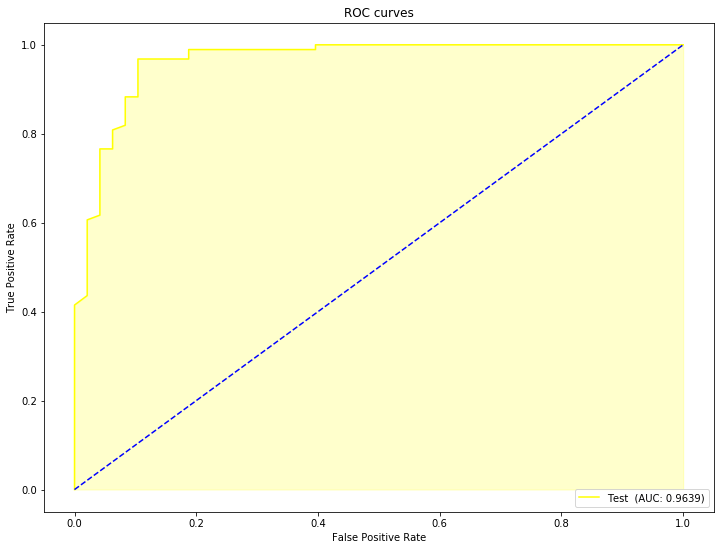

In [140]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(
                            test[feature_columns])[:, 1],
                        pos_label=1.0
                        )
df_roc_test = pd.DataFrame({"fpr": fpr,
                            "tpr": tpr})

auc_test = roc_auc_score(test['status'],
                         model.predict_proba(test[feature_columns])[:, 1])

# ROC plotting
plt.figure(figsize=(12, 9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"],
         "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0, 1], [0, 1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"],
                 y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [141]:
auc_test

0.9638741134751773

In [142]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [143]:
auc_train

1.0

**COMENTARIO**: Tras realizar validación cruzada, el AUC en test y en train sigue siendo similar.

Aunque parezca raro que el AUC sea tan alto, no es un problema de sobreajuste ya que se ha probado el modelo entrenando con distintos conjuntos y se ha evaluado sobre un conjunto de test con el que no se ha entrenado el modelo y aún así sale igual de alto **(al final probamos también validación cruzada repetida)**

**Evaluación del modelo: Matriz de confusión y métricas**

Hasta ahora hemos evaluado los modelos mediante el AUC, ya que es la métrica más adecuada para comparar modelos (se basa en cómo de bien clasifica el modelo para distintos umbrales). 

Sin embargo, hay otras métricas más fáciles de interpretar: las relacionadas con la matriz de confusión. Calcularemos dichas métricas sobre los datos de test para el último modelo obtenido.

Estas métricas se basan en comparar los valores reales de la variable target con los valores predichos por el modelo (estos se pueden obtener con *model.predict*). El threshold por defecto es 0.5, es decir: cuando el scoring proporcionado por el modelo es superior a 0.5, se clasifica la observación como 1 (Success). Como el dataset se ha balanceado al aplicar el modelo, un threshold de 0.5 será adecuado.

In [144]:
# valores predichos por el modelo
pred_model3_1_best = model.predict(test[feature_columns])

Calculamos la matriz de confusión sobre los datos de test a partir de los valores reales y los predichos:

In [80]:
conf_model3_1 = confusion_matrix(test['status'], pred_model3_1_best)

In [81]:
conf_model3_1

array([[37, 14],
       [ 2, 89]], dtype=int64)

Hay 14 observaciones en test que el modelo clasifica como Success y en realidad fueron Failed, y 2 observaciones que el modelo clasificó como Failed y en realidad fueron Sucess

Ahora, calculamos las distintas métricas derivadas de esta matriz de confusión e interpretamos resultados:

In [82]:
precision_model3_1 = precision_score(test['status'], pred_model3_1_best)
recall_model3_1 = recall_score(test['status'], pred_model3_1_best)
f1_model3_1 = f1_score(test['status'], pred_model3_1_best)
accuracy_model3_1 = accuracy_score(test['status'], pred_model3_1_best)

In [83]:
precision_model3_1

0.8640776699029126

- Interpretación precision: Un 89.4% de las observaciones clasificadas como 1, realmente son 1 (de las empresas que determinamos que van a tener éxito, un 89.4% realmente lo tienen)

In [84]:
recall_model3_1

0.978021978021978

- Interpretación recall: El modelo consigue detectar un 91.5% de las empresas que van a tener éxito (de entre todas las empresas que realmente tienen éxito, un 91.5% fueron predichas por el modelo)

In [85]:
f1_model3_1

0.9175257731958761

- Interpretación f1: compromiso entre precision y recall

In [86]:
accuracy_model3_1

0.8873239436619719

- Interpretación accuracy: El modelo acierta un 88.7% de las veces

### Modelo 3_2: Transformación PROPORTION, AUC > 0.6. RF + Grid search Repeated Cross Validation

Probamos el último modelo, pero con validación cruzada repetida

In [143]:
model3_2_rf= RandomForestClassifier(class_weight='balanced')

param_grid3_2 = {"n_estimators": [100, 200, 300, 500, 1000],  # hiperparámetros a probar (todas las combinaciones posibles)
                 "max_features": ["sqrt", 0.3, 0.6],
                 "max_depth": [None, 10, 15, 20, 30],
                 "min_samples_split": [2, 5, 10],
                 "n_jobs": [-1],
                 "class_weight": ["balanced"]
                 }


rkf3_2 = RepeatedKFold(n_splits=5, n_repeats=5, random_state=2652124)

grid3_2 = GridSearchCV(estimator=model3_2_rf,
                     param_grid=param_grid3_2,
                     scoring="roc_auc", # métrica de evaluación: AUC
                     cv=rkf3_2, # usamos el repeated k-fold definido
                     verbose=3)

In [144]:
model3_2 = grid3_2.fit(train3[vars_selected_prop3],
                       train3['status'])  # prueba 375 modelos diferentes (5 conjuntos de entrenamiento por cada combinación del grid)

Fitting 25 folds for each of 225 candidates, totalling 5625 fits
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.978, total=   3.0s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.913, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.928, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.943, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=2, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.913, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.973, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.995, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.947, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.961, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.924, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.958, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.914, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.928, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=5, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.948, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.935, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.987, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.911, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_est

[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.955, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.996, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.955, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.933, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.915, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.971, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.958, total=   1.1s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=100

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.959, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.902, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.932, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=5, n_estimators=1000, n_

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.902, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.955, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.957, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   1.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.906, total=   0.9s
[CV] class_weight=balanced, max_depth=None, max_features=0.3, min_samples_split=10, n_esti

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.931, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.975, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.943, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.952, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.907, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.952, total=   0.8s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.926, total=   1.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.974, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=2, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.914, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.905, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.998, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.941, total=   1.0s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.944, total=   1.2s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=5, n_estimators=1

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.916, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.908, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.945, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.923, total=   0.3s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.907, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.995, total=   0.4s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   0.6s
[CV] class_weight=balanced, max_depth=None, max_features=0.6, min_samples_split=10, n_estimators=

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.990, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.912, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.995, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.981, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.933, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jo

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.970, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.976, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.934, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.957, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.985, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.910, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.930, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.930, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.910, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.962, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.982, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.923, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.909, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.955, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.935, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.924, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.997, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.960, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.946, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.966, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV] 

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.926, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.941, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.975, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.976, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.927, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.963, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.982, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.970, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.925, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.928, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.996, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.977, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.919, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.6s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.909, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.968, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.910, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.927, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.969, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.922, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.983, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.908, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.915, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.997, total=   1.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   0.9s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.974, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.964, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.978, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.909, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.947, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.997, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.947, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.895, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.954, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.907, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.998, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.940, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.975, total=   1.1s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.970, total=   0.8s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.923, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.957, total=   1.0s
[CV] class_weight=balanced, max_depth=10, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.987, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.906, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.936, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.993, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.973, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.934, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.962, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.988, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.973, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.918, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.929, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.987, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.916, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.943, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.928, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.961, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.929, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.972, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.905, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.955, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.966, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.985, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.959, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.939, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.925, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=500, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.961, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=100, n_jo

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.961, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.946, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.976, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.910, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.988, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.934, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.922, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.996, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.979, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.974, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.9s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.982, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.913, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.936, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.928, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.997, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.942, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.984, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.956, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.962, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.909, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.948, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.931, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.918, total=   1.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.3, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.954, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.937, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.976, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.968, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.959, total=   0.5s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.980, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.901, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.927, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.922, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.997, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.940, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.978, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.923, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  c

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.944, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.980, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.910, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.924, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.998, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.943, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.970, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.945, total=   0.8s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.976, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.911, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.912, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.907, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.995, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.946, total=   0.3s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.977, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.969, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.923, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.956, total=   0.4s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.981, total=   0.6s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.903, total=   1.1s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.0s
[CV] class_weight=balanced, max_depth=15, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.943, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.993, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.940, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.950, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.980, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.928, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.991, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.921, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.958, total=   0.8s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.930, total=   0.8s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.997, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_j

[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.936, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.987, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.931, total=   0.2s


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.964, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.983, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.944, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.928, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.997, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.965, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.978, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.974, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.905, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.958, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.961, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.961, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.942, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.933, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=1000, 

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.956, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.905, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.940, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.975, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.910, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.988, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.986, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.925, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.921, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.947, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.958, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.982, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.912, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.936, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.997, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.952, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.935, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.973, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.975, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.901, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.954, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.978, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.946, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.933, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.924, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.959, total=   1.1s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.958, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.3, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.938, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.987, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.954, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.906, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.958, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.988, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.919, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.949, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.977, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.972, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.904, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.962, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.946, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.981, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.924, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.997, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.940, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.970, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.920, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.979, total=   1.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.907, total=   0.9s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.915, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.998, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.977, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.903, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.960, total=   0.5s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.980, total=   0.6s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.978, total=   1.0s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.939, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.919, total=   0.7s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.914, total=   1.3s
[CV] class_weight=balanced, max_depth=20, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.950, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.967, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.933, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.973, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.962, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.911, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.965, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.985, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.960, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.954, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.967, total=   1.1s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.942, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jo

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.945, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.920, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.931, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.973, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.981, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.955, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.950, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.952, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.957, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.967, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=5, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.938, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.964, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.920, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=100, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.969, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.924, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.971, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.983, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=200, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.956, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=300, n_j

[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.955, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.940, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.960, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_split=10, n_estimators=1

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.919, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.974, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.938, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.944, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.953, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.965, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.964, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.942, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.966, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1, score=0.911, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.964, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.929, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.978, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.983, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.939, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.948, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.966, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.958, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1, score=0.909, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.932, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.975, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.984, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.955, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.948, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.956, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.959, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.960, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.959, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.939, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.959, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1, score=0.900, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.922, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.969, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.982, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.941, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.953, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.951, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.958, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.3, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.915, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.963, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.934, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1, score=0.957, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.951, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.927, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.979, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1, score=0.985, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=200, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.958, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1, score=0.948, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.944, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.951, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.905, total=   1.1s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1, score=0.965, total=   1.0s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=2, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.932, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.978, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.985, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1, score=0.945, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=100, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.949, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.963, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.950, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=200, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=300, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.946, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.906, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.963, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1, score=0.954, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=500, n_jobs=-1 
[CV]  cl

[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.977, total=   0.8s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.982, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.938, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1, score=0.925, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=5, n_estimators=1000, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.949, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.960, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.953, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1, score=0.941, total=   0.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.937, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.947, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.901, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1, score=0.960, total=   0.3s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=300, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.917, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.972, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.978, total=   0.5s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1, score=0.938, total=   0.4s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=500, n_jobs=-1 


[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   0.6s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.947, total=   1.2s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.961, total=   0.9s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1 
[CV]  class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_jobs=-1, score=0.950, total=   0.7s
[CV] class_weight=balanced, max_depth=30, max_features=0.6, min_samples_split=10, n_estimators=1000, n_j

[Parallel(n_jobs=1)]: Done 5625 out of 5625 | elapsed: 40.6min finished


**Elección del mejor modelo**

Aquí se muestra un resumen de todos los modelos entrenados: el primero es el que tiene mayor media de AUC en los datos de validación (mean_test_score)

In [145]:
pd.DataFrame(model3_2.cv_results_).sort_values(by="mean_test_score", ascending=False) 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
181       0.130146      0.006388         0.106240        0.000937   
97        0.176367      0.007155         0.105825        0.000966   
49        0.689893      0.186996         0.147064        0.051147   
91        0.173026      0.043883         0.107284        0.001672   
138       0.334763      0.084390         0.106959        0.001486   
93        0.373374      0.119505         0.115501        0.028630   
184       0.679043      0.198388         0.146793        0.051316   
182       0.175610      0.005732         0.105621        0.000707   
9         0.683377      0.197617         0.147152        0.050795   
1         0.141699      0.008911         0.108097        0.003052   
139       0.692334      0.192136         0.163873        0.051767   
142       0.192330      0.010709         0.107499        0.001617   
54        0.714451      0.199892         0.159804        0.052087   
136       0.135185      0.004875         0.106191        0.000615   
48        0.396936      0.133816         0.111238        0.020222   
7         0.206327      0.048911         0.107209        0.001604   
137       0.193264      0.009046         0.107132        0.001443   
3         0.277681      0.015647         0.107032        0.001632   
183       0.274233      0.011268         0.106135        0.001384   
94        0.680011      0.184434         0.154899        0.051761   
92        0.248813      0.078606         0.107653        0.001687   
2         0.188149      0.012395         0.107630        0.002944   
0         0.219097      0.547775         0.107674        0.001515   
45        0.111511      0.025385         0.108137        0.001950   
144       0.721723      0.189502         0.168095        0.051192   
99        0.673165      0.190030         0.151113        0.051837   
4         0.664240      0.198346         0.142944        0.050248   
98        0.344932      0.107136         0.106847        0.001395   
52        0.184594      0.016555         0.106959        0.001453   
186       0.129964      0.004971         0.106276        0.000824   
188       0.336670      0.104510         0.106749        0.001344   
46        0.145336      0.011451         0.107270        0.001178   
110       0.106516      0.010589         0.108643        0.001547   
18        0.274481      0.010420         0.106759        0.001454   
96        0.126895      0.004383         0.106149        0.000885   
135       0.110084      0.013931         0.109170        0.001565   
47        0.207725      0.038480         0.107292        0.002308   
143       0.340318      0.095765         0.106824        0.002003   
51        0.178079      0.061170         0.107155        0.001595   
17        0.211832      0.053782         0.107661        0.001585   
53        0.408748      0.136291         0.107357        0.001460   
189       0.653390      0.192084         0.142924        0.050648   
106       0.142673      0.010127         0.106291        0.001060   
64        0.737471      0.210675         0.179935        0.074555   
141       0.141684      0.017179         0.106754        0.002177   
19        0.675760      0.197095         0.146384        0.050691   
95        0.110799      0.023957         0.107791        0.001321   
8         0.312028      0.091037         0.106874        0.001478   
187       0.177658      0.006133         0.106046        0.000877   
199       0.685472      0.174286         0.163629        0.051412   
109       0.719378      0.185703         0.154886        0.051956   
62        0.208217      0.019833         0.106952        0.001226   
6         0.140926      0.007453         0.107379        0.001031   
140       0.115519      0.021551         0.108381        0.001786   
153       0.389883      0.114074         0.107221        0.001497   
204       0.674875      0.211545         0.138875        0.048864   
63        0.350036      0.113455         0.107146        0.001387   
69 

In [146]:
model3_2_best=model3_2.best_estimator_ #mejor modelo

In [147]:
feat_importances_model3_2 = pd.DataFrame(model3_2_best.feature_importances_,
                                   index = vars_selected_prop3,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [148]:
feat_importances_model3_2

importance
number_sales_support_material                0.125302
specialization_highest_education             0.081999
focus_structured_unstructured_data           0.073840
relevance_experience_venture                 0.072412
renowned_professional_circle                 0.064707
relevance_education_venture                  0.060762
focus_functions                              0.051452
catering_product_service_across_verticals    0.044553
gartner_hype_cycle_stage                     0.044206
top_management_similarity                    0.039112
focus_private_or_public_data                 0.037107
team_size_senior_lead                        0.033944
local_or_global_player                       0.032670
top_forums_talking_about_company             0.031441
industry_trend_investing                     0.030806
big_data_business                            0.029243
aggregator_or_market_place                   0.027198
employee_benefits_salary_structures          0.024035
degree_tier1_tier2_university                0.020851
number_cofounders                            0.020325
B2C_or_B2B                                   0.015805
consulting_experience                        0.015113
barriers_entry_competitors                   0.013830
predictive_analytics_business                0.009286

**Evaluación del modelo: Curva ROC y AUC**

In [149]:
test = test3
model = model3_2_best
feature_columns = vars_selected_prop3

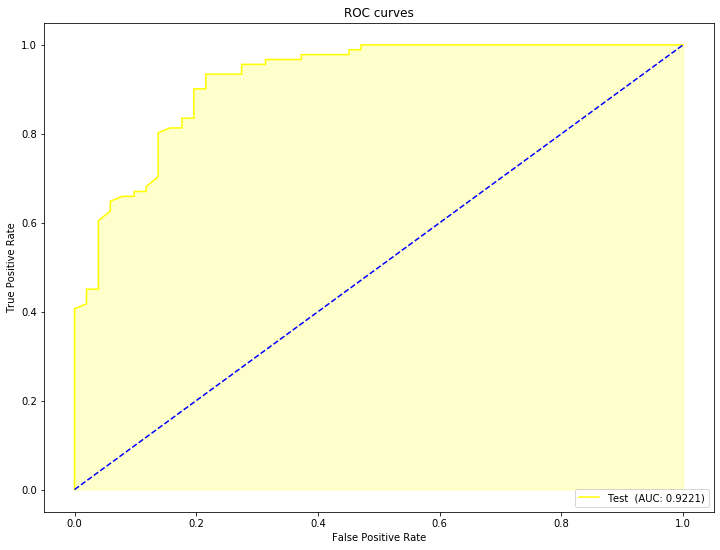

In [150]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict_proba(test[feature_columns])[:,1],
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict_proba(test[feature_columns])[:,1])

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [151]:
auc_test

0.9221073044602457

In [152]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict_proba(train3[feature_columns])[:,1])

In [153]:
auc_train

1.0

Sale similar al modelo sin validación cruzada repetida

### Modelo 4: Transformación PROPORTION, AUC>0.6. Regresion Lasso. VCR

In [32]:
df_model4 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [33]:
df_model4.columns

Index(['company_name', 'status', 'relevance_experience_venture',
       'relevance_education_venture', 'focus_structured_unstructured_data',
       'local_or_global_player', 'big_data_business',
       'top_management_similarity', 'renowned_professional_circle',
       'degree_tier1_tier2_university', 'team_size_senior_lead',
       'number_sales_support_material', 'B2C_or_B2B',
       'catering_product_service_across_verticals',
       'top_forums_talking_about_company', 'gartner_hype_cycle_stage',
       'aggregator_or_market_place', 'focus_private_or_public_data',
       'focus_functions', 'employee_benefits_salary_structures',
       'specialization_highest_education', 'consulting_experience',
       'number_cofounders', 'predictive_analytics_business',
       'industry_trend_investing', 'barriers_entry_competitors'],
      dtype='object')

In [34]:
model4_lasso = Lasso(normalize=True, max_iter=10000)
param = {'alpha': [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5]}

rkf4 = RepeatedKFold(n_splits=5, n_repeats=10)

grid4 = GridSearchCV(estimator=model4_lasso,
                     param_grid=param,
                     scoring="roc_auc",  # métrica de evaluación: AUC
                     cv=rkf4,
                     verbose=3)

model4 = grid4.fit(train3[vars_selected_prop3], train3['status'])

Fitting 50 folds for each of 7 candidates, totalling 350 fits
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.892, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.878, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.928, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.961, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.927, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.849, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... alpha=1e-06, score=0.946, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.972, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.887, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.827, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.896, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.915, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.926, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] .

[CV] ......................... alpha=0.001, score=0.948, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.797, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.948, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.960, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.881, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.877, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.908, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.500, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .

[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] ............................. alpha=5, score=0.500, total=   0.0s
[CV] alpha=5 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    1.6s finished


In [35]:
pd.DataFrame(model4.cv_results_).sort_values(by="mean_test_score", ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
1       0.002301      0.000411         0.001766        0.000343      0.0001   
0       0.002639      0.000863         0.002247        0.001478       1e-06   
2       0.002465      0.003145         0.001568        0.000426       0.001   
3       0.002018      0.000322         0.001575        0.000255        0.01   
4       0.001952      0.000261         0.001447        0.000127         0.1   
5       0.002393      0.000671         0.001905        0.000656           1   
6       0.001999      0.000346         0.001609        0.000312           5   

              params  split0_test_score  split1_test_score  split2_test_score  \
1  {'alpha': 0.0001}           0.891865           0.878049           0.927686   
0   {'alpha': 1e-06}           0.891865           0.878049           0.927686   
2   {'alpha': 0.001}           0.871032           0.869268           0.934917   
3    {'alpha': 0.01}           0.748512           0.794146           0.926653   
4     {'alpha': 0.1}           0.500000           0.500000           0.500000   
5       {'alpha': 1}           0.500000           0.500000           0.500000   
6       {'alpha': 5}           0.500000           0.500000           0.500000   

   split3_test_score  split4_test_score  split5_test_score  split6_test_score  \
1           0.962927           0.926876           0.849074           0.945602   
0           0.960976           0.926876           0.849074           0.945602   
2           0.959024           0.914530           0.846296           0.949074   
3           0.862439           0.807217           0.825926           0.898727   
4           0.500000           0.500000           0.500000           0.500000   
5           0.500000           0.500000           0.500000           0.500000   
6           0.500000           0.500000           0.500000           0.500000   

   split7_test_score  split8_test_score  split9_test_score  \
1           0.929171           0.930769           0.933696   
0           0.929171           0.930769           0.933696   
2           0.930103           0.914423           0.929348   
3           0.901212           0.826923           0.895652   
4           0.500000           0.500000           0.500000   
5           0.500000           0.500000           0.500000   
6           0.500000           0.500000           0.500000   

   split10_test_score  split11_test_score  split12_test_score  \
1            0.877066            0.875594            0.941014   
0            0.877066            0.874644            0.943779   
2            0.860537            0.866097            0.920737   
3            0.801136            0.821937            0.780184   
4            0.500000            0.500000            0.500000   
5            0.500000            0.500000            0.500000   
6            0.500000            0.500000            0.500000   

   split13_test_score  split14_test_score  split15_test_score  \
1            0.934028            0.963902            0.901923   
0            0.934028            0.962927            0.895192   
2            0.943287            0.967805            0.905769   
3            0.908565            0.895610            0.854808   
4            0.500000            0.500000            0.500000   
5            0.500000            0.500000            0.500000   
6            0.500000            0.500000            0.500000   

   split16_test_score  split17_test_score  split18_test_score  \
1            0.952174            0.919110            0.893519   
0            0.953261            0.924166            0.891667   
2            0.932609            0.875632            0.885185   
3            0.873913            0.743680            0.856944   
4            0.500000            0.500000            0.500000   
5            0.500000            0.500000            0.500000   
6            0.500000            0.500000            0.500000   

   split19_t

In [36]:
model4_lasso2 = Lasso(alpha=0.0001, normalize=True, max_iter=10000)

model4_2 = model4_lasso2.fit(train3[vars_selected_prop3], train3['status'])

**Importancia de variables**

In [37]:
# Importancia de variables según parámetros
feat_importances_model4 = pd.DataFrame(abs(model4_2.coef_),
                                       index=vars_selected_prop3,
                                       columns=['importance']).sort_values('importance', ascending=False)
feat_importances_model4

importance
focus_private_or_public_data                 1.109606
predictive_analytics_business                1.076316
number_sales_support_material                1.011496
top_management_similarity                    0.987154
barriers_entry_competitors                   0.940344
catering_product_service_across_verticals    0.742760
focus_structured_unstructured_data           0.731287
specialization_highest_education             0.519151
local_or_global_player                       0.358904
employee_benefits_salary_structures          0.350180
big_data_business                            0.325245
B2C_or_B2B                                   0.318697
relevance_experience_venture                 0.252233
top_forums_talking_about_company             0.206802
aggregator_or_market_place                   0.196878
relevance_education_venture                  0.133469
focus_functions                              0.122376
degree_tier1_tier2_university                0.120117
gartner_hype_cycle_stage                     0.050594
number_cofounders                            0.036252
industry_trend_investing                     0.023003
team_size_senior_lead                        0.004922
renowned_professional_circle                 0.000260
consulting_experience                        0.000000

**Validaciones y métricas**

In [38]:
test = test3
model = model4_2
feature_columns = vars_selected_prop3

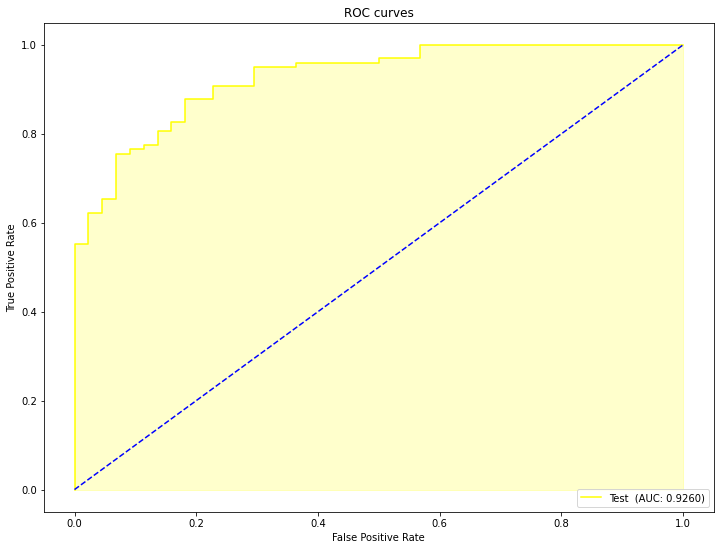

In [39]:
fpr, tpr, _ = roc_curve(y_true=test['status'],
                        y_score=model.predict(test[feature_columns]),
                        pos_label=1.0
                       )
df_roc_test = pd.DataFrame({"fpr":fpr, 
                            "tpr":tpr})

auc_test = roc_auc_score(test['status'], 
                         model.predict(test[feature_columns]))

# ROC plotting
plt.figure(figsize=(12,9))

# ROC curves:
plt.plot(df_roc_test["fpr"], df_roc_test["tpr"], "yellow", label="Test  (AUC: %.4f)" % auc_test)

# Random guess:
plt.plot([0,1],[0,1], "b--")

# Colour
plt.fill_between(x=df_roc_test["fpr"], y1=df_roc_test["tpr"], alpha=0.2, color="yellow")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc=4, fontsize=10)
pass

In [40]:
auc_test

0.9260204081632653

In [41]:
auc_train = roc_auc_score(train3['status'], 
                         model.predict(train3[feature_columns]))
auc_train

0.9435607399552257

In [42]:
# Valores predichos, punto de corte 0.64
predict = model4_2.predict(test[feature_columns])
map_iterator = map(lambda x: 1 if x >= 0.64 else 0, predict)
pred_model4 = list(map_iterator)

In [44]:
predict

array([ 8.28459085e-01,  7.29777262e-01,  6.79638772e-01,  7.62876364e-01,
        6.93283623e-02,  4.65599279e-01,  1.17964614e+00,  6.82264208e-01,
        1.15152365e+00, -2.16223890e-01, -9.83808799e-02, -1.50539996e-01,
        3.70925448e-01,  4.82277451e-01,  9.88017459e-01, -7.18843306e-02,
        1.09126759e+00,  1.01111783e+00,  1.21344538e+00,  1.27050699e-01,
        6.96952657e-01,  6.28447012e-01,  4.71301369e-02,  7.38572228e-01,
        1.20116695e+00, -1.54231562e-01,  5.85889509e-01,  1.05278435e+00,
        3.74787274e-01,  4.56524670e-01,  3.71812453e-01,  4.18848724e-01,
        5.82383206e-01,  5.21433859e-01,  5.10833537e-01,  6.03761750e-01,
        1.84484348e-01,  6.05728217e-01,  1.17969596e+00,  8.13946675e-02,
        1.88328588e-01,  7.98561773e-01,  9.60602291e-01,  1.07259407e+00,
        3.57877581e-01,  5.90168969e-01, -1.85561367e-01,  9.40195404e-01,
        9.85499510e-01,  8.01947413e-01,  9.02483822e-01,  6.47988100e-01,
        5.94216229e-01,  

In [43]:
conf_model4 = pd.DataFrame(confusion_matrix(test['status'], pred_model4, labels=[0, 1]),
                           index=['true: failed', 'true: success'],
                           columns=['pred: failed', 'pred: success'])
print(conf_model4)

               pred: failed  pred: success
true: failed             40              4
true: success            23             75


In [237]:
precision_model4 = precision_score(test['status'], pred_model4) # Precisión en la detección de Success
precision_model4

0.9425287356321839

In [238]:
recall_model4 = recall_score(test['status'], pred_model4) # Capacidad de detectar Success
recall_model4

0.8723404255319149

In [239]:
f1_model4 = f1_score(test['status'], pred_model4) # Compromiso entre precisión y recall
f1_model4

0.9060773480662984

In [240]:
accuracy_model4 = accuracy_score(test['status'], pred_model4) # Tasa de acierto
accuracy_model4

0.8802816901408451

### Modelo 5: Transformación PROPORTION, AUC>0.6. Gradient Boosting. VCR

In [251]:
df_model5 = df_startups_prop[['company_name'] + ['status'] + vars_selected_prop3]

In [200]:
model5_gb = GradientBoostingClassifier()
param = {'learning_rate': [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5],
         'n_estimators': [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5],
         'subsample': [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5],
         'min_samples_split': [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5],
         'max_features': ["sqrt", "log2", 0.3, 0.6]}

rkf5 = RepeatedKFold(n_splits=5, n_repeats=10)

grid5 = GridSearchCV(estimator=model5_gb,
                     param_grid=param,
                     scoring="roc_auc",  # métrica de evaluación: AUC
                     cv=rkf5,
                     verbose=3)

model5 = grid5.fit(train3[vars_selected_prop3], train3['status'])

Fitting 50 folds for each of 7 candidates, totalling 350 fits
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.889, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.931, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.932, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.853, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.865, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.936, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... alpha=1e-06, score=0.933, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.922, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.906, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.928, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.874, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.907, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] ......................... alpha=1e-06, score=0.921, total=   0.0s
[CV] alpha=1e-06 .....................................................
[CV] .

[CV] ......................... alpha=0.001, score=0.858, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.935, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.890, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.836, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.914, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.965, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......................... alpha=0.001, score=0.863, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .

[CV] .......................... alpha=0.01, score=0.774, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.883, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.769, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.872, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.870, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.874, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.790, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .

[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.500, total=   0.0s
[CV] a

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    2.3s finished
